# CNN

In [133]:
import numpy as np
from abc import ABCMeta, abstractmethod


class MLPLayer(metaclass=ABCMeta):
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass


class CNNLayer(MLPLayer, metaclass=ABCMeta):
    def im2col(self, img, FH, FW, stride, pad):
        N, C, H, W = img.shape
        #FN, C, FH, FW = filters.shape
        # フィルタ適用後のimageサイズ
        OH = (H + 2*pad - FH) // stride + 1
        OW = (W + 2*pad - FW) // stride + 1
        img_padded = np.pad(img, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, FH, FW, OH, OW), dtype=np.float32)
        for y in range(FH):
            ymax = y + stride * OH
            for x in range(FW):
                xmax = x + stride * OW
                col[:, :, y, x, :, :] = img_padded[:, :, y:ymax:stride, x:xmax:stride]
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*OH*OW, -1)
        return col
    
    def col2im(self, col, img_shape, FH, FW, stride, pad):
        N, C, H, W = img_shape
        #FN, C, FH, FW = filters.shape
        OH = (H + 2*pad - FH) // stride + 1
        OW = (W + 2*pad - FW) // stride + 1
        
        col_reshaped = col.reshape(N, OH, OW, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        
        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1), dtype=np.float32)
        
        for y in range(FH):
            ymax = y + stride * OH
            for x in range(FW):
                xmax = x + stride * OW
                img[:, :, y:ymax:stride, x:xmax:stride] += col_reshaped[:, :, y, x, :, :]
        img = img[:, :, pad:pad+H, pad:pad+W]
        return img
        

class Convolution(CNNLayer):
    """
    Attributes
    ----------
    filters : numpy array (FN, C, FH, FW)
        FN : 出力チャンネル数
        C  : 入力チャンネル数
        FH : フィルタの行数
        FW : フィルタの列数
    bias : numpy array
    stride : 
    pad : 
    """
    def __init__(self, filters, bias, stride=1, pad=0):
        self.filters = filters
        self.bias = bias
        self.stride = stride
        self.pad = pad
        self.dF = None
        self.db = None
        self.img = None
        self.col_img = None
        self.col_filters = None
    
    def forward(self, img, is_training=False):
        FN, C, FH, FW = self.filters.shape
        N, C, H, W = img.shape
        #H, W = H + self.pad * 2, W + self.pad * 2
        
        col_img = self.im2col(img, FH, FW, stride=self.stride, pad=self.pad).T
        col_filters = self.filters.reshape(FN, -1)
        
        OH = (H + self.pad * 2 - FH) // self.stride + 1
        OW = (W + self.pad * 2 - FW) // self.stride + 1
        
        if (OH - 1) * self.stride - self.pad * 2 + FH != H or (OW - 1) * self.stride - self.pad * 2 + FW != W:
            raise Exception('ストライド幅が不適')
        
        if is_training:
            self.img = img
            self.col_img = col_img
            self.col_filters = col_filters
        
        out = (np.dot(col_filters, col_img).T + self.bias).T
        out = out.reshape(FN, N, OH, OW).transpose(1, 0, 2, 3)
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.filters.shape
        #N, C, H, W = dout.shape
        
        dout_reshaped = dout.transpose(0,2,3,1).reshape(-1, FN) # N, H, W, C
        self.db = dout_reshaped.sum(axis=0)
        self.dF = np.dot(self.col_img, dout_reshaped).T.reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout_reshaped, self.col_filters)
        dimg = self.col2im(dcol, self.img.shape, FH, FW, self.stride, self.pad)
        
        self.img = None
        self.col_img = None
        self.col_filters = None
        
        return dimg


class MaxPooling(CNNLayer):
    def __init__(self, PH, PW, stride=1, pad=0):
        self.PH = PH
        self.PW = PW
        self.stride = stride
        self.pad = pad
        self.img = None
        self.max_args = None
    
    def forward(self, img, is_training=False):
        N, C, H, W = img.shape
        OH = (H + self.pad * 2 - self.PH) // self.stride + 1
        OW = (W + self.pad * 2 - self.PW) // self.stride + 1
        
        col_img = self.im2col(img, self.PH, self.PW, self.stride, self.pad).reshape(-1, self.PH*self.PW)
        max_args = col_img.argmax(axis=1)
        out = col_img.max(axis=1).reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
        
        if is_training:
            self.img = img
            self.max_args = max_args
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)  # N, H, W, C
        
        pool_size = self.PH * self.PW
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.max_args.size), self.max_args.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dimg = self.col2im(dcol, self.img.shape, self.PH, self.PW, self.stride, self.pad)
        
        self.img = None
        self.max_args = None
        
        return dimg


class Flatten(MLPLayer):
    def __init__(self):
        self.img_shape = None
    
    def forward(self, img, is_training=False):
        """
        (N, C, H, W) -> (N, C*H*W) -> (C*H*W, N)
        """
        img_shape = img.shape
        out = img.reshape(img_shape[0], -1).T
        
        if is_training:
            self.img_shape = img_shape
        
        return out
    
    def backward(self, dout):
        """
        (C*H*W, N) -> (N, C*H*W) -> (N, C, H, W)
        """
        dimg = dout.T.reshape(self.img_shape)
        self.img_shape = None
        return dimg


class Affine(MLPLayer):
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.A_with_bias = None

    def forward(self, A, is_training=False):
        A_with_bias = np.full((A.shape[0]+1, A.shape[1]), 1.0)
        A_with_bias[1:] = A
        out = np.dot(self.W, A_with_bias)
        
        if is_training:
            self.A_with_bias = A_with_bias
        
        return out

    def backward(self, dout):
        dA = np.dot(self.W.T[1:], dout)
        self.dW = np.dot(dout, self.A_with_bias.T)
        self.A_with_bias = None
        return dA


class ReLU(MLPLayer):
    def __init__(self):
        self.mask = None
    
    def forward(self, Z, is_training=False):
        mask = Z <= 0
        out = Z.copy()
        out[mask] = 0
        
        if is_training:
            self.mask = mask
        
        return out
    
    def backward(self, dout):
        dphi = np.full(self.mask.shape, 1.0)
        dphi[self.mask] = 0
        dZ = dout * dphi
        self.mask = None
        return dZ


class SoftMax(MLPLayer):
    eps = 1e-8
    
    def __init__(self):
        self.Y = None
    
    def forward(self, Z, is_training=False):
        Z_exp = np.exp(Z)
        Y = Z_exp / (Z_exp.sum(axis=0) + self.eps)
        
        if is_training:
            self.Y = Y
        
        return Y
    
    def backward(self, dout):
        dZ = self.Y * (dout - np.sum(self.Y * dout, axis=0))
        self.Y = None
        return dZ


class CostCalculation(MLPLayer):
    eps = 1e-8
    
    def __init__(self):
        self.Y_predict = None
        self.Y_correct = None
    
    def forward(self, Y_predict, Y_correct):
        self.Y_predict = Y_predict
        self.Y_correct = Y_correct
        cost = - np.sum(Y_correct * np.log(Y_predict) + (1.0 - Y_correct) * np.log(1.0 - Y_predict), axis=0)
        cost = np.average(cost)
        return cost
    
    def backward(self, dout=1.0):
        batch_size = self.Y_predict.shape[1]
        dA = (self.Y_predict - self.Y_correct) / (self.Y_predict * (1.0 - self.Y_predict) + self.eps) / batch_size
        self.Y_predict = None
        self.Y_correct = None
        return dA


class BatchNormalization(MLPLayer):
    def __init__(self, h_units, eps=1e-8, gamma=1.0, beta=0):
        self.h_units = h_units
        self.eps = eps
        self.gamma = gamma
        self.beta = beta
        self.std = None
        self.Z_norm = None
        self.dgamma = None
        self.dbeta = None
    
    def forward(self, Z, is_training=False):
        shape = Z.shape
        if len(shape) > 2:
            Z = Z.reshape(shape[0], -1).T
        
        mu = np.average(Z, axis=0)
        std = np.std(Z, axis=0)
        Z_norm = (Z - mu) / np.sqrt(std**2 + self.eps)
        out = self.gamma * Z_norm + self.beta
        
        if len(shape) > 2:
            out = out.T.reshape(shape)
        
        if is_training:
            self.std = std
            self.Z_norm = Z_norm
        
        return out
    
    def backward(self, dout):
        shape = dout.shape
        if len(shape) > 2:
            dout = dout.reshape(shape[0], -1).T
        
        self.dgamma = (dout * self.Z_norm).sum(axis=0)
        self.dbeta = dout.sum(axis=0)
        dZ = self.gamma / (self.h_units * np.sqrt(self.std**2 + self.eps)) * (
            self.h_units * dout - self.dbeta - self.Z_norm * self.dgamma
        )
        
        if len(shape) > 2:
            dZ = dZ.T.reshape(shape)
        
        self.std = None
        self.Z_norm = None
        
        return dZ


class Dropout(MLPLayer):
    def __init__(self, ratio=0.5):
        self.ratio = ratio
        self.mask = None
    
    def forward(self, x, is_training=False):
        if is_training:
            self.mask = np.random.rand(*x.shape) > self.ratio
            return x * self.mask
        else:
            return x * (1.0 - self.ratio)
    
    def backward(self, dout):
        dx = dout * self.mask
        self.mask = None
        return dx

In [383]:
import numpy
from datetime import datetime

class CNN:
    def __init__(self, FN, FH, FW, PH, PW, h_units, h_layers, c_layers, epochs, eta, n_batch, l2=0,
                 dropout_ratio=0.5, stride_filter=1, pad_filter=0, stride_pool=1, pad_pool=0):
        self.eta = eta
        self.epochs = epochs
        self.n_batch = n_batch
        self.l2 = l2
        self.dropout_ratio = dropout_ratio
        self.FN = FN
        self.FH = FH
        self.FW = FW
        self.stride_filter = stride_filter
        self.pad_filter = pad_filter
        self.PH = PH
        self.PW = PW
        self.stride_pool = stride_pool
        self.pad_pool = pad_pool
        self.h_units = h_units
        self.h_layers = h_layers
        self.c_layers = c_layers
        self.cost = None
        self.mse_train = None
        self.mse_test = None
        self.accuracy_train = None
        self.accuracy_test = None
    
    def predict(self, data):
        out = data.copy()
        for layer in self.layers:
            out = layer.forward(out)
        i_label = np.argmax(out, axis=0)
        return self.index2label[i_label]
    
    def fit(self, data_train, labels_train, data_test, labels_test):
        """
        Parameters
        ----------
        data : numpy array (N, C, H, W)
            入力画像データ
            - N : データ件数
            - C : 画像のチャンネル数
            - H : 画像の高さ（行数）
            - W : 画像の幅（列数）
        """
        N, C, H, W = data_train.shape
        N_test = len(labels_test)
        
        self.index2label = np.unique(labels_train)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        T = len(self.index2label)
        
        Y = np.zeros([T, N])
        for i in range(N):
            l = labels_train[i]
            Y[self.label2index[l]][i] = 1.0
        Y_test = np.zeros([T, N_test])
        for i in range(N_test):
            l = labels_test[i]
            Y_test[self.label2index[l]][i] = 1.0
        
        if self.cost is None:
            # モデルの初期化
            OH = H
            OW = W
            
            self.layers = []
            c = C
            for _ in range(self.c_layers):
                filters = np.random.randn(self.FN, c, self.FH, self.FW) * 0.01
                bias = np.zeros(self.FN)
                self.layers.extend([
                    Convolution(filters, bias, pad=self.pad_filter, stride=self.stride_filter),
                    BatchNormalization(c*OH*OW),
                    ReLU(),
                    MaxPooling(self.PH, self.PW, stride=self.stride_pool, pad=self.pad_pool)
                ])
                OH = (OH + self.pad_filter * 2 - self.FH) // self.stride_filter + 1
                OH = (OH + self.pad_pool * 2 - self.PH) // self.stride_pool + 1
                OW = (OW + self.pad_filter * 2 - self.FW) // self.stride_filter + 1
                OW = (OW + self.pad_pool * 2 - self.PW) // self.stride_pool + 1
                c = self.FN
            
            self.layers.append(Flatten())
            
            w = np.random.randn(self.h_units, self.FN*OH*OW+1) * 0.01
            for _ in range(self.h_layers):
                self.layers.extend([
                    Dropout(ratio=self.dropout_ratio),
                    Affine(w),
                    BatchNormalization(w.shape[1]-1),
                    ReLU()
                ])
                w = np.random.randn(self.h_units, self.h_units + 1) * 0.01
            
            w = np.random.randn(T, self.h_units+1) * 0.01
            self.layers.extend([
                Dropout(ratio=self.dropout_ratio),
                Affine(w),
                SoftMax()
            ])
            
            self.cost_layer = CostCalculation()
        
            self.cost = []
            self.mse_train = []
            self.mse_test = []
        
        for _ in range(self.epochs):
            now = datetime.now()
            print('epoch {} --- {}'.format(len(self.cost)+1, now.strftime('%Y/%m/%d %H:%M:%S')))
            max_iteration = max(N//self.n_batch, 1)
            for i in range(max_iteration):
                ids = np.random.choice(range(N), self.n_batch, replace=False)
                X_part = data_train[ids]
                Y_part = Y[:, ids]
                
                # フォワードプロパゲーション
                out = X_part
                for layer in self.layers:
                    if isinstance(layer, Dropout):
                        out = layer.forward(out, is_training=True)
                    else:
                        out = layer.forward(out)
                    
                
                # バックプロパゲーション
                cost = self.cost_layer.forward(out, Y_part)
                if i == max_iteration - 1:
                    self.cost.append(cost)
                
                dout = self.cost_layer.backward()
                dx = dout.copy()
                for layer in reversed(self.layers):
                    dx = layer.backward(dx)
                
                # L2正則化項を勾配に追加
                for layer in self.layers:
                    if isinstance(layer, Affine):
                        layer.dW += self.l2 * layer.W
                    elif isinstance(layer, BatchNormalization):
                        layer.dgamma += self.l2 * layer.gamma
                        layer.dbeta += self.l2 * layer.beta
                    elif isinstance(layer, Convolution):
                        layer.dF += self.l2 * layer.filters
                        layer.db += self.l2 * layer.bias
                
                self.__update()
            
            # 評価
            ids_eval = np.random.choice(range(N), N_test, replace=False)
            Y_pred_train = data_train[ids_eval]
            for layer in self.layers:
                Y_pred_train = layer.forward(Y_pred_train)
            Y_pred_test = data_test.copy()
            for layer in self.layers:
                Y_pred_test = layer.forward(Y_pred_test)
            self.mse_train.append(self.__calc_mse(Y[:, ids_eval], Y_pred_train))
            self.mse_test.append(self.__calc_mse(Y_test, Y_pred_test))
        
    def __update(self):
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.W -= self.eta * layer.dW
            elif isinstance(layer, BatchNormalization):
                layer.gamma -= self.eta * layer.dgamma.sum()
                layer.beta -= self.eta * layer.dbeta.sum()
            elif isinstance(layer, Convolution):
                layer.filters -= self.eta * layer.dF
                layer.bias -= self.eta * layer.db
    
    def __calc_mse(self, Y, Y_pred):
        return np.average(Y.argmax(axis=0) == Y_pred.argmax(axis=0))
        return np.average(((Y-Y_pred)**2).sum(axis=0))
    
    def __calc_accuracy(self, Y, Y_pred):
        return np.average(Y.argmax(axis=0) == Y_pred.argmax(axis=0))

In [289]:
data = []
labels = []

def load_data(filename):
    data = []
    labels = []
    with open(filename) as f:
        lines = f.readlines()
        h, w = lines[0].split(',')
        h, w = int(h), int(w)
        for l in lines[1:]:
            arr = l.split(',')
            labels.append(arr[0])
            data.append([float(v) for v in arr[1:]])
        data = np.array(data).reshape(-1, 1, h, w)
        labels = np.array(labels)
    return data, labels

data_train, labels_train = load_data('../data/mnist/mnist_train')
data_test, labels_test = load_data('../data/mnist/mnist_test')

# 時間がかかる場合はこちらの小さい方のデータを使う
data_train_s, labels_train_s = data_train[:5000], labels_train[:5000]
data_test_s, labels_test_s = data_test[:1000], labels_test[:1000]

epoch 11 --- 2020/06/19 15:49:15
epoch 12 --- 2020/06/19 15:49:25
epoch 13 --- 2020/06/19 15:49:35
epoch 14 --- 2020/06/19 15:49:45
epoch 15 --- 2020/06/19 15:49:55
epoch 16 --- 2020/06/19 15:50:04
epoch 17 --- 2020/06/19 15:50:14
epoch 18 --- 2020/06/19 15:50:24
epoch 19 --- 2020/06/19 15:50:34
epoch 20 --- 2020/06/19 15:50:43


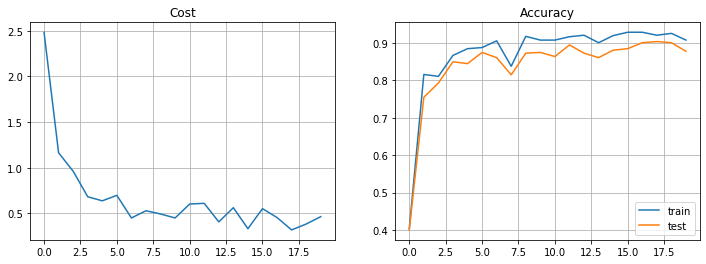

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7,2,1,0,4,1,4,9,6,9,0,6,9,0,1,5,9,7,8,4
1,7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4
2,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,False,True


In [305]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

np.seterr(all='raise')

#cnn = CNN(FN=30, FH=3, FW=3, PH=2, PW=2, h_units=100, h_layers=2, c_layers=2, epochs=20, eta=1e-1, n_batch=128, l2=0.,
#          stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)
cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, c_layers=1, epochs=20, eta=1e-1, n_batch=128, l2=1e-3,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

#cnn.fit(data_train, labels_train, data_test, labels_test)  # 1エポックに1分強かかる
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Cost')
plt.plot(range(len(cnn.cost)), cnn.cost)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(range(len(cnn.mse_train)), cnn.mse_train, label='train')
plt.plot(range(len(cnn.mse_test)), cnn.mse_test, label='test')
plt.grid()
plt.legend()
plt.show()

pd.DataFrame([
    cnn.predict(data_test[:20]),
    labels_test[:20],
    cnn.predict(data_test[:20]) == labels_test[:20]
])

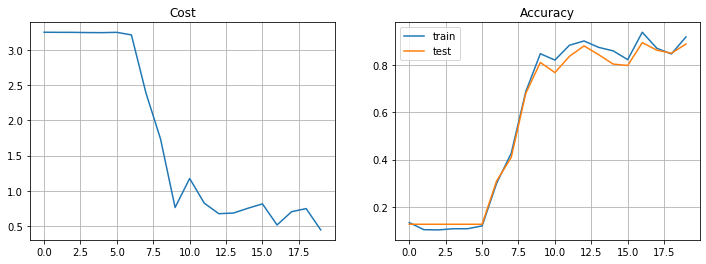

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7,2,1,0,4,1,4,9,6,9,0,6,9,0,1,5,9,7,3,4
1,7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4
2,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True


In [253]:
# BNなし
# cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, c_layers=1, epochs=20, eta=1e-1, n_batch=128, l2=0.05,
#           stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

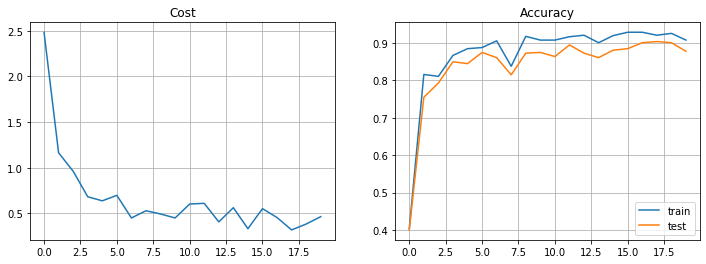

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7,2,1,0,4,1,4,9,6,9,0,6,9,0,1,5,9,7,8,4
1,7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4
2,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,False,True


In [306]:
# BNあり
# cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, h_layers=1, c_layers=1, epochs=20, eta=1e-1, n_batch=128, l2=1e-3,
#           stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

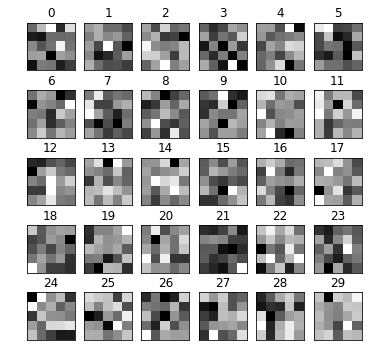

epoch 1 --- 2020/06/17 21:06:12
epoch 2 --- 2020/06/17 21:06:19
epoch 3 --- 2020/06/17 21:06:26
epoch 4 --- 2020/06/17 21:06:33
epoch 5 --- 2020/06/17 21:06:39
epoch 6 --- 2020/06/17 21:06:46
epoch 7 --- 2020/06/17 21:06:53
epoch 8 --- 2020/06/17 21:07:00
epoch 9 --- 2020/06/17 21:07:07
epoch 10 --- 2020/06/17 21:07:14
epoch 11 --- 2020/06/17 21:07:21
epoch 12 --- 2020/06/17 21:07:28
epoch 13 --- 2020/06/17 21:07:35
epoch 14 --- 2020/06/17 21:07:42
epoch 15 --- 2020/06/17 21:07:49
epoch 16 --- 2020/06/17 21:07:55
epoch 17 --- 2020/06/17 21:08:03
epoch 18 --- 2020/06/17 21:08:10
epoch 19 --- 2020/06/17 21:08:16
epoch 20 --- 2020/06/17 21:08:23


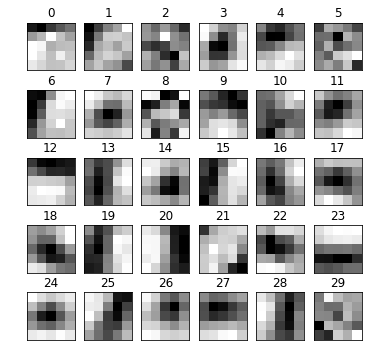

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, epochs=0, eta=1e-1, n_batch=100,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(6, 6))
for i in range(cnn.FN):
    plt.subplot(cnn.FN//6, 6, i+1)
    plt.title(i)
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
plt.show()


cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, epochs=20, eta=1e-1, n_batch=100,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(6, 6))
for i in range(cnn.FN):
    plt.subplot(cnn.FN//6, 6, i+1)
    plt.title(i)
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
plt.show()

# 実際の画像処理

In [146]:
# 画像読み込み
from PIL import Image, UnidentifiedImageError
import numpy as np
import os

IMG_SIZE=128

def load_images(img_dir):
    images = []
    for img_file in os.listdir(path=img_dir):
        try:
            img = Image.open(img_dir + '/' + img_file).convert('RGB').resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            images.append(np.asarray(img).transpose(2, 0, 1))
        except UnidentifiedImageError as e:
            print(e)
    print('{} images are loaded'.format(len(images)))
    return images

img_dirs = {
    'ladybug': '../data/image-net/images/ladybug',
    'spider': '../data/image-net/images/wolf_spider'
    #'garden_spider': '../data/image-net/images/garden_spider',
    #'cockroach': '../data/image-net/images/cockroach'
}
images = {}

n_min = np.inf
for label, dir_path in img_dirs.items():
    images[label] = load_images(dir_path)
    if len(images[label]) < n_min:
        n_min = len(images[label])
data = []
labels = []
for k, v in images.items():
    data.extend(v[:n_min])
    labels.extend([k] * n_min)

data = np.array(data) / 255.0
labels = np.array(labels)

cannot identify image file '../data/image-net/images/ladybug/.DS_Store'
1536 images are loaded
cannot identify image file '../data/image-net/images/wolf_spider/78230725.MKK5RW7B.jpg'
cannot identify image file '../data/image-net/images/wolf_spider/proxy.aspx?Method=GetBinaryContent&Channel=InfoBinary&Target=http:%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2Fthumb%2F3%2F38%2FWolf_spider_single_frame.jpg%2F250px-Wolf_spider_single_frame.jpg'
cannot identify image file '../data/image-net/images/wolf_spider/wolf_spider_4.jpg'
cannot identify image file '../data/image-net/images/wolf_spider/Spankie_Wolf Spider.JPG'
1160 images are loaded


In [438]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

N_train = 1000
N_test = 400

N = len(data)
ids = np.array(range(N))
np.random.shuffle(ids)

data_train, labels_train = data[ids[:N_train]], labels[ids[:N_train]]
data_test, labels_test = data[ids[N_train:N_train+N_test]], labels[ids[N_train:N_train+N_test]]


cnn = CNN(FN=32, FH=3, FW=3, PH=2, PW=2, h_units=32, h_layers=1, c_layers=2, epochs=10, eta=1e-2, n_batch=64, l2=2e-3,
          dropout_ratio=0.3, stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

epoch 101 --- 2020/06/19 21:52:03
epoch 102 --- 2020/06/19 21:52:31
epoch 103 --- 2020/06/19 21:52:57
epoch 104 --- 2020/06/19 21:53:24
epoch 105 --- 2020/06/19 21:53:50
epoch 106 --- 2020/06/19 21:54:16
epoch 107 --- 2020/06/19 21:54:41
epoch 108 --- 2020/06/19 21:55:07
epoch 109 --- 2020/06/19 21:55:33
epoch 110 --- 2020/06/19 21:56:00


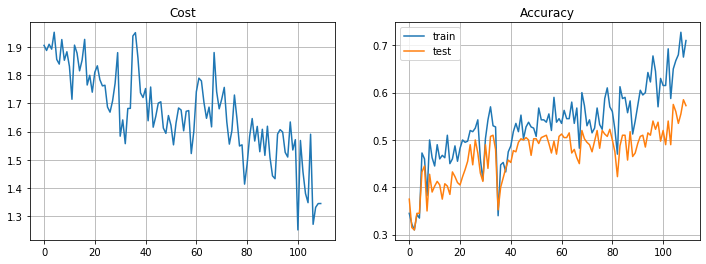

------------------------------------------------------------
cockroach: 0.6231884057971014 (86 / 138)
ladybug: 0.5 (64 / 128)
spider: 0.5895522388059702 (79 / 134)
------------------------------------------------------------
epoch 111 --- 2020/06/19 21:56:30
epoch 112 --- 2020/06/19 21:56:57
epoch 113 --- 2020/06/19 21:57:23
epoch 114 --- 2020/06/19 21:57:52
epoch 115 --- 2020/06/19 21:58:19
epoch 116 --- 2020/06/19 21:58:45
epoch 117 --- 2020/06/19 21:59:11
epoch 118 --- 2020/06/19 21:59:37
epoch 119 --- 2020/06/19 22:00:03
epoch 120 --- 2020/06/19 22:00:30


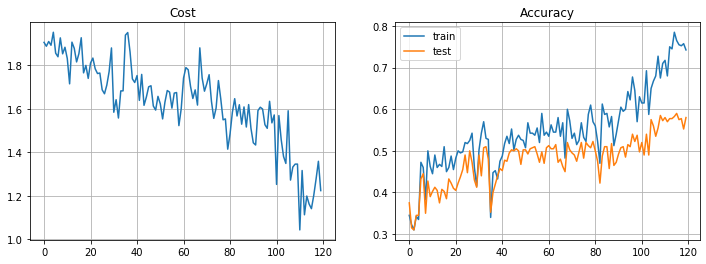

------------------------------------------------------------
cockroach: 0.644927536231884 (89 / 138)
ladybug: 0.65625 (84 / 128)
spider: 0.44029850746268656 (59 / 134)
------------------------------------------------------------
epoch 121 --- 2020/06/19 22:01:00
epoch 122 --- 2020/06/19 22:01:28
epoch 123 --- 2020/06/19 22:01:56
epoch 124 --- 2020/06/19 22:02:22
epoch 125 --- 2020/06/19 22:02:51
epoch 126 --- 2020/06/19 22:03:20
epoch 127 --- 2020/06/19 22:03:50
epoch 128 --- 2020/06/19 22:04:17
epoch 129 --- 2020/06/19 22:04:43
epoch 130 --- 2020/06/19 22:05:10


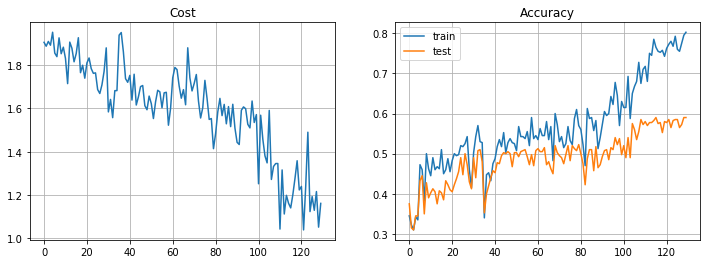

------------------------------------------------------------
cockroach: 0.5144927536231884 (71 / 138)
ladybug: 0.734375 (94 / 128)
spider: 0.5298507462686567 (71 / 134)
------------------------------------------------------------
epoch 131 --- 2020/06/19 22:05:42
epoch 132 --- 2020/06/19 22:06:09
epoch 133 --- 2020/06/19 22:06:35
epoch 134 --- 2020/06/19 22:07:01
epoch 135 --- 2020/06/19 22:07:27
epoch 136 --- 2020/06/19 22:07:54
epoch 137 --- 2020/06/19 22:08:20
epoch 138 --- 2020/06/19 22:08:50
epoch 139 --- 2020/06/19 22:09:19
epoch 140 --- 2020/06/19 22:09:46


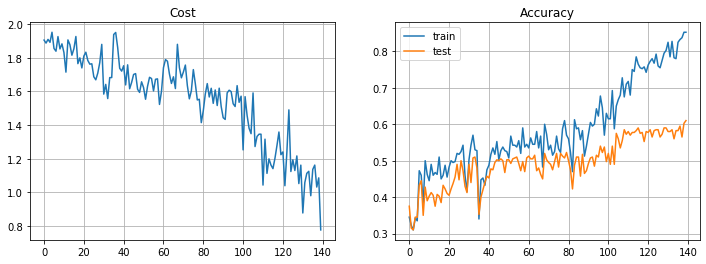

------------------------------------------------------------
cockroach: 0.6014492753623188 (83 / 138)
ladybug: 0.71875 (92 / 128)
spider: 0.5149253731343284 (69 / 134)
------------------------------------------------------------
epoch 141 --- 2020/06/19 22:10:17
epoch 142 --- 2020/06/19 22:10:43
epoch 143 --- 2020/06/19 22:11:10
epoch 144 --- 2020/06/19 22:11:36
epoch 145 --- 2020/06/19 22:12:03
epoch 146 --- 2020/06/19 22:12:29
epoch 147 --- 2020/06/19 22:12:55
epoch 148 --- 2020/06/19 22:13:22
epoch 149 --- 2020/06/19 22:13:48
epoch 150 --- 2020/06/19 22:14:14


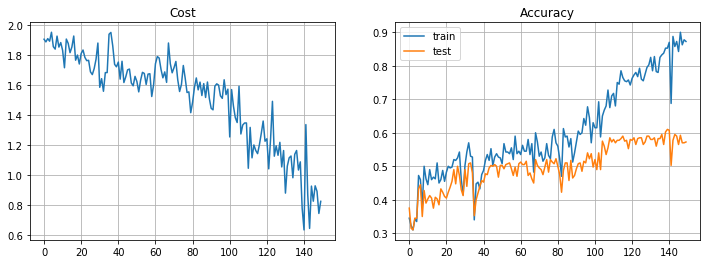

------------------------------------------------------------
cockroach: 0.6956521739130435 (96 / 138)
ladybug: 0.5859375 (75 / 128)
spider: 0.43283582089552236 (58 / 134)
------------------------------------------------------------
epoch 151 --- 2020/06/19 22:14:46
epoch 152 --- 2020/06/19 22:15:13
epoch 153 --- 2020/06/19 22:15:40
epoch 154 --- 2020/06/19 22:16:08
epoch 155 --- 2020/06/19 22:16:35
epoch 156 --- 2020/06/19 22:17:02
epoch 157 --- 2020/06/19 22:17:28
epoch 158 --- 2020/06/19 22:17:55
epoch 159 --- 2020/06/19 22:18:24
epoch 160 --- 2020/06/19 22:18:53


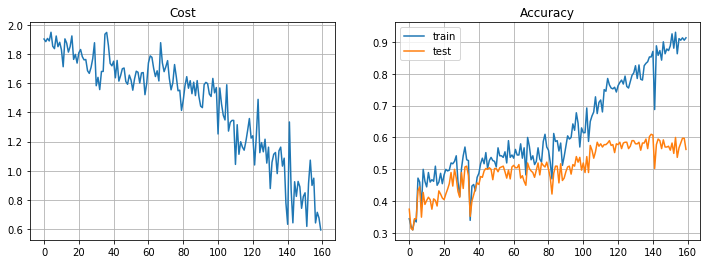

------------------------------------------------------------
cockroach: 0.5942028985507246 (82 / 138)
ladybug: 0.5859375 (75 / 128)
spider: 0.5074626865671642 (68 / 134)
------------------------------------------------------------
epoch 161 --- 2020/06/19 22:19:27


KeyboardInterrupt: 

In [413]:
for i in range(10):
    cnn.fit(data_train, labels_train, data_test, labels_test)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title('Cost')
    plt.plot(range(len(cnn.cost)), cnn.cost)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(range(len(cnn.mse_train)), cnn.mse_train, label='train')
    plt.plot(range(len(cnn.mse_test)), cnn.mse_test, label='test')
    plt.grid()
    plt.legend()
    plt.show()

    """
    plt.figure(figsize=(6, 6))
    for i in range(cnn.FN):
        plt.subplot(cnn.FN//6, 6, i+1)
        plt.title(i)
        plt.xticks(color="None")
        plt.yticks(color="None")
        plt.tick_params(length=0)
        plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
    plt.show()
    """

    print('------------------------------------------------------------')
    for l in np.unique(labels_test):
        ids = labels_test == l
        imgs = data_test[ids]
        l_pred = cnn.predict(imgs)
        n_total = np.count_nonzero(ids)
        n_ok = np.count_nonzero(l_pred == l)
        print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))
    print('------------------------------------------------------------')

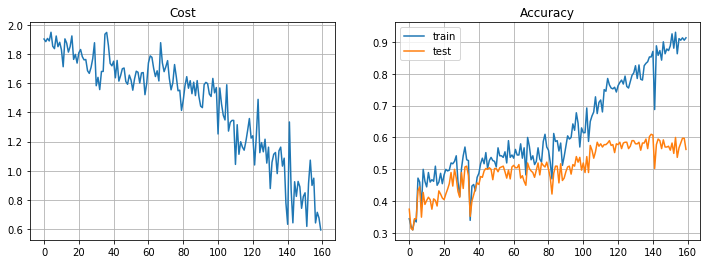

cockroach: 0.7554980595084088 (584 / 773)
ladybug: 0.7516170763260026 (581 / 773)
spider: 0.6532988357050453 (505 / 773)


In [414]:
# BN, Dropoutあり, 1000, 400
# 64x64 image, Conv-ReLU-Pool-Conv-ReLU-Pool-ReLU-SoftMax
# cnn = CNN(FN=32, FH=3, FW=3, PH=2, PW=2, h_units=32, h_layers=1, c_layers=2, epochs=10, eta=1e-2, n_batch=64, l2=2e-3,
#           dropout_ratio=0.3, stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

if True:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title('Cost')
    plt.plot(range(len(cnn.cost)), cnn.cost)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(range(len(cnn.mse_train)), cnn.mse_train, label='train')
    plt.plot(range(len(cnn.mse_test)), cnn.mse_test, label='test')
    plt.grid()
    plt.legend()
    plt.show()


for l in np.unique(labels):
    ids = labels == l
    imgs = data[ids]
    l_pred = cnn.predict(imgs)
    n_total = np.count_nonzero(ids)
    n_ok = np.count_nonzero(l_pred == l)
    print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))

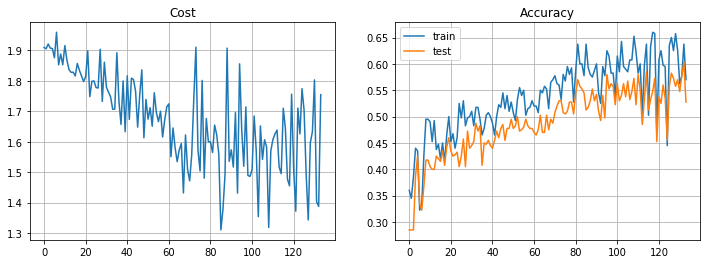

cockroach: 0.018111254851228976 (14 / 773)
ladybug: 0.23673997412677877 (183 / 773)
spider: 0.9896507115135834 (765 / 773)


In [393]:
# BN, Dropoutあり, 1000, 400
# 64x64 image, Conv-ReLU-Pool-Conv-ReLU-Pool-ReLU-SoftMax
# cnn = CNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=16, h_layers=1, c_layers=2, epochs=5, eta=1e-2, n_batch=64, l2=2e-3,
#           dropout_ratio=0.3, stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

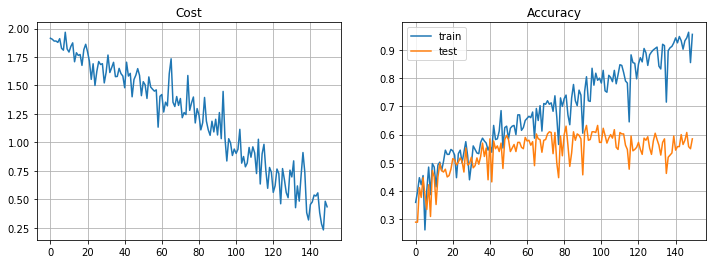

In [357]:
# BNあり, 1000, 400
# 64x64 image, Conv-ReLU-Pool-Conv-ReLU-Pool-ReLU-SoftMax
# cnn = CNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=16, h_layers=1, c_layers=2, epochs=5, eta=1e-2, n_batch=64, l2=2e-3,
#           stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

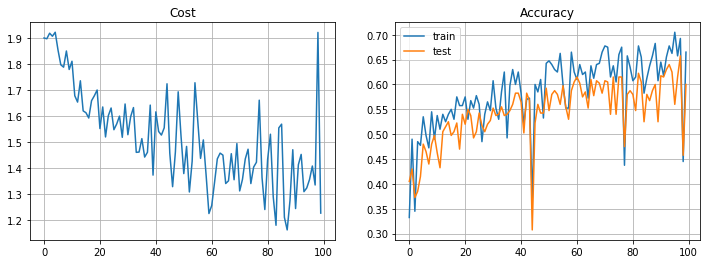

In [351]:
# BNあり, 1000, 400
# 64x64 image, Conv-ReLU-Pool-Conv-ReLU-Pool-ReLU-SoftMax
# cnn = CNN(FN=8, FH=3, FW=3, PH=2, PW=2, h_units=8, h_layers=1, c_layers=2, epochs=5, eta=1e-2, n_batch=64, l2=2e-3,
#           stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

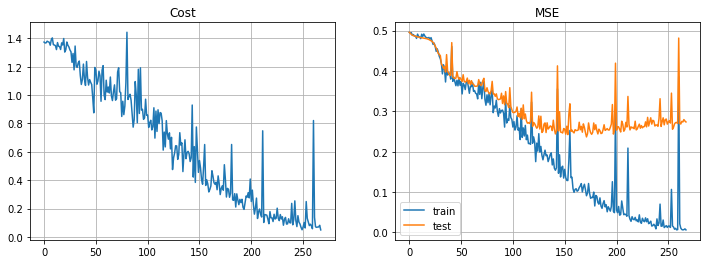

In [84]:
# BNなし
# 64x64 image, Conv-ReLU-Pool-ReLU-SoftMax
# FN=30, FH=3, FW=3, PH=2, PW=2, h_units=100, epochs=1, eta=1e-2, n_batch=100, l2=0,
# stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0

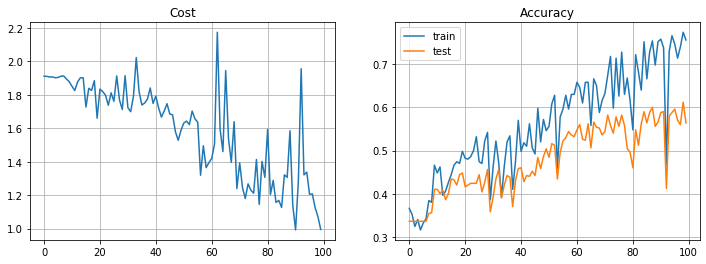

In [234]:
# BNなし
# 28x28 image, Conv-ReLU-Pool-ReLU-SoftMax
# cnn = CNN(FN=30, FH=3, FW=3, PH=2, PW=2, h_units=100, h_layers=1, c_layers=1, epochs=10, eta=1e-1, n_batch=128, l2=0.002,
#           stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

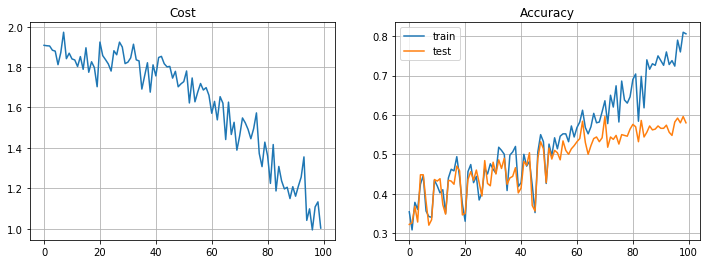

In [240]:
# BNなし
# 64x64 image, Conv-ReLU-Pool-ReLU-SoftMax
# cnn = CNN(FN=30, FH=3, FW=3, PH=2, PW=2, h_units=100, h_layers=1, c_layers=1, epochs=5, eta=1e-1, n_batch=128, l2=0.01,
#           stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

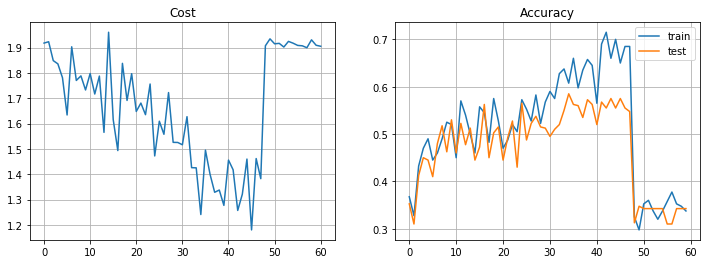

In [347]:
# BNあり, 1000, 400
# 64x64 image, Conv-ReLU-Pool-ReLU-SoftMax
# cnn = CNN(FN=8, FH=3, FW=3, PH=2, PW=2, h_units=8, h_layers=1, c_layers=2, epochs=5, eta=1e-1, n_batch=64, l2=2e-3,
#           stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

# VGG
- 学習データ増やす（回転・切り取り）
- 学習率が大きくて最適解に至っていない可能性。学習率小さくする
- 隠れ層のユニット数増やす（4096?）
- 隠れ層なくす（MaxPooling -> Flatten -> Affine -> SoftMax）
- 虫の判定が難しい可能性。犬猫とか、もうちょっと簡単そうなやつで試してみる（個人のブログとかで精度出てるやつ探す？）
- 単純な勾配降下法ではなく Adam とか試してみる

In [134]:
import numpy
from datetime import datetime

class VGGLikeCNN:
    def __init__(self, FN, FH, FW, PH, PW, h_units, h_layers, c_layers, epochs, eta, n_batch, l2=0,
                 dtype=np.float32, dropout_ratio=0.5, stride_filter=1, pad_filter=0, stride_pool=1, pad_pool=0):
        self.eta = eta
        self.epochs = epochs
        self.n_batch = n_batch
        self.l2 = l2
        self.dtype = dtype
        self.dropout_ratio = dropout_ratio
        self.FN = FN
        self.FH = FH
        self.FW = FW
        self.stride_filter = stride_filter
        self.pad_filter = pad_filter
        self.PH = PH
        self.PW = PW
        self.stride_pool = stride_pool
        self.pad_pool = pad_pool
        self.h_units = h_units
        self.h_layers = h_layers
        self.c_layers = c_layers
        self.cost = None
        self.mse_train = None
        self.mse_test = None
        self.accuracy_train = None
        self.accuracy_test = None
    
    def predict(self, data):
        out = data.copy()
        for layer in self.layers:
            out = layer.forward(out)
        i_label = np.argmax(out, axis=0)
        return self.index2label[i_label]
    
    def fit(self, data_train, labels_train, data_test, labels_test):
        """
        Parameters
        ----------
        data : numpy array (N, C, H, W)
            入力画像データ
            - N : データ件数
            - C : 画像のチャンネル数
            - H : 画像の高さ（行数）
            - W : 画像の幅（列数）
        """
        N, C, H, W = data_train.shape
        N_test = len(labels_test)
        
        self.index2label = np.unique(labels_train)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        T = len(self.index2label)
        
        Y = np.zeros([T, N], dtype=self.dtype)
        for i in range(N):
            l = labels_train[i]
            Y[self.label2index[l]][i] = 1.0
        Y_test = np.zeros([T, N_test], dtype=self.dtype)
        for i in range(N_test):
            l = labels_test[i]
            Y_test[self.label2index[l]][i] = 1.0
        
        if self.cost is None:
            # モデルの初期化
            OH = H
            OW = W
            
            self.layers = []
            c = C
            fn = self.FN
            for _ in range(self.c_layers):
                for i in range(2):
                    filters = np.random.randn(fn, c, self.FH, self.FW).astype(self.dtype) * 0.01
                    bias = np.zeros(fn, dtype=self.dtype)
                    self.layers.extend([
                        Convolution(filters, bias, pad=self.pad_filter, stride=self.stride_filter),
                        BatchNormalization(c*OH*OW),
                        ReLU()
                    ])
                    c = fn
                self.layers.append(MaxPooling(self.PH, self.PW, stride=self.stride_pool, pad=self.pad_pool))
                OH = (OH + self.pad_filter * 2 - self.FH) // self.stride_filter + 1
                OH = (OH + self.pad_pool * 2 - self.PH) // self.stride_pool + 1
                OW = (OW + self.pad_filter * 2 - self.FW) // self.stride_filter + 1
                OW = (OW + self.pad_pool * 2 - self.PW) // self.stride_pool + 1
                fn *= 2
                
            
            self.layers.append(Flatten())
            
            on = fn//2*OH*OW
            for _ in range(self.h_layers):
                w = np.random.randn(self.h_units, on+1).astype(self.dtype) * 0.01
                self.layers.extend([
                    Dropout(ratio=self.dropout_ratio),
                    Affine(w),
                    BatchNormalization(w.shape[1]-1),
                    ReLU()
                ])
                on = self.h_units
            
            w = np.random.randn(T, on+1).astype(self.dtype) * 0.01
            self.layers.extend([
                Dropout(ratio=self.dropout_ratio),
                Affine(w),
                Dropout(ratio=self.dropout_ratio),
                SoftMax()
            ])
            
            self.cost_layer = CostCalculation()
        
            self.cost = []
            self.mse_train = []
            self.mse_test = []
        
        for _ in range(self.epochs):
            now = datetime.now()
            print('epoch {} --- {}'.format(len(self.cost)+1, now.strftime('%Y/%m/%d %H:%M:%S')))
            max_iteration = max(N//self.n_batch, 1)
            for i in range(max_iteration):
                ids = np.random.choice(range(N), self.n_batch, replace=False)
                X_part = data_train[ids]
                Y_part = Y[:, ids]
                
                # フォワードプロパゲーション
                out = X_part
                for layer in self.layers:
                    out = layer.forward(out, is_training=True)
                cost = self.cost_layer.forward(out, Y_part)
                if i == max_iteration - 1:
                    self.cost.append(cost)
                
                # バックプロパゲーション
                dout = self.cost_layer.backward()
                dx = dout.copy()
                for layer in reversed(self.layers):
                    dx = layer.backward(dx)
                
                # L2正則化項を勾配に追加
                for layer in self.layers:
                    if isinstance(layer, Affine):
                        layer.dW += self.l2 * layer.W
                    elif isinstance(layer, BatchNormalization):
                        layer.dgamma += self.l2 * layer.gamma
                        layer.dbeta += self.l2 * layer.beta
                    elif isinstance(layer, Convolution):
                        layer.dF += self.l2 * layer.filters
                        layer.db += self.l2 * layer.bias
                
                self.__update()
            
            # 評価
            ids_eval = np.random.choice(range(N), N_test, replace=False)
            Y_pred_train = data_train[ids_eval]
            for layer in self.layers:
                Y_pred_train = layer.forward(Y_pred_train)
            Y_pred_test = data_test.copy()
            for layer in self.layers:
                Y_pred_test = layer.forward(Y_pred_test)
            self.mse_train.append(self.__calc_mse(Y[:, ids_eval], Y_pred_train))
            self.mse_test.append(self.__calc_mse(Y_test, Y_pred_test))
        
    def __update(self):
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.W -= self.eta * layer.dW
            elif isinstance(layer, BatchNormalization):
                layer.gamma -= self.eta * layer.dgamma.sum()
                layer.beta -= self.eta * layer.dbeta.sum()
            elif isinstance(layer, Convolution):
                layer.filters -= self.eta * layer.dF
                layer.bias -= self.eta * layer.db
    
    def __calc_mse(self, Y, Y_pred):
        return np.average(Y.argmax(axis=0) == Y_pred.argmax(axis=0))
        return np.average(((Y-Y_pred)**2).sum(axis=0))
    
    def __calc_accuracy(self, Y, Y_pred):
        return np.average(Y.argmax(axis=0) == Y_pred.argmax(axis=0))

In [147]:
import numpy as np
import pickle

N_train = 1000
N_test = 500

N = len(data)
ids = np.array(range(N))
np.random.shuffle(ids)

dtype = np.float32

data_train, labels_train = data[ids[:N_train]].astype(dtype), labels[ids[:N_train]]
data_test, labels_test = data[ids[N_train:N_train+N_test]].astype(dtype), labels[ids[N_train:N_train+N_test]]

with open('../data/tmp/data_train.pkl', 'xb') as f:
    pickle.dump(data_train, f)
with open('../data/tmp/data_test.pkl', 'xb') as f:
    pickle.dump(data_test, f)
with open('../data/tmp/labels_train.pkl', 'xb') as f:
    pickle.dump(labels_train, f)
with open('../data/tmp/labels_test.pkl', 'xb') as f:
    pickle.dump(labels_test, f)

In [150]:
vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=1024, h_layers=1, c_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
                 dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)

epoch 1 --- 2020/06/24 19:50:17
epoch 2 --- 2020/06/24 19:54:45
epoch 3 --- 2020/06/24 19:59:01
epoch 4 --- 2020/06/24 20:03:14
epoch 5 --- 2020/06/24 20:07:30
epoch 6 --- 2020/06/24 20:11:46
epoch 7 --- 2020/06/24 20:16:02
epoch 8 --- 2020/06/24 20:20:18
epoch 9 --- 2020/06/24 20:24:34
epoch 10 --- 2020/06/24 20:28:50


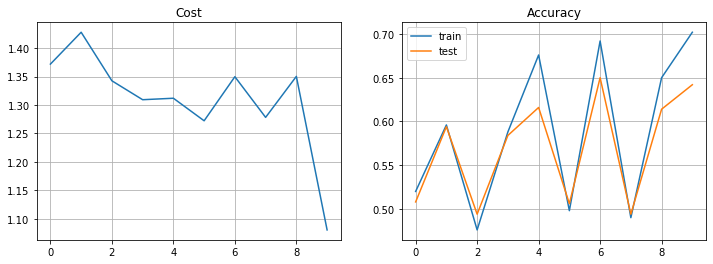

------------------------------------------------------------
ladybug: 0.782608695652174 (198 / 253)
spider: 0.4979757085020243 (123 / 247)
------------------------------------------------------------
epoch 11 --- 2020/06/24 20:33:41
epoch 12 --- 2020/06/24 20:38:12
epoch 13 --- 2020/06/24 20:42:48
epoch 14 --- 2020/06/24 20:47:07
epoch 15 --- 2020/06/24 20:51:23
epoch 16 --- 2020/06/24 20:55:35
epoch 17 --- 2020/06/24 20:59:48
epoch 18 --- 2020/06/24 21:04:02
epoch 19 --- 2020/06/24 21:08:15
epoch 20 --- 2020/06/24 21:12:28


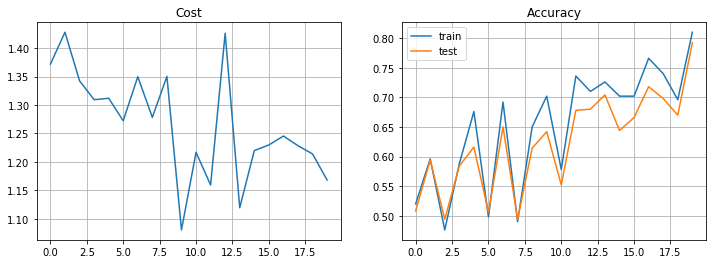

------------------------------------------------------------
ladybug: 0.7905138339920948 (200 / 253)
spider: 0.7935222672064778 (196 / 247)
------------------------------------------------------------
epoch 21 --- 2020/06/24 21:17:15
epoch 22 --- 2020/06/24 21:21:31
epoch 23 --- 2020/06/24 21:25:48
epoch 24 --- 2020/06/24 21:30:04
epoch 25 --- 2020/06/24 21:34:20
epoch 26 --- 2020/06/24 21:38:36
epoch 27 --- 2020/06/24 21:42:52
epoch 28 --- 2020/06/24 21:47:09
epoch 29 --- 2020/06/24 21:51:25
epoch 30 --- 2020/06/24 21:55:42


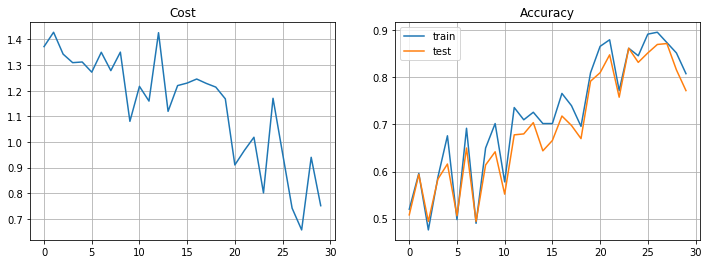

------------------------------------------------------------
ladybug: 0.5691699604743083 (144 / 253)
spider: 0.979757085020243 (242 / 247)
------------------------------------------------------------
epoch 31 --- 2020/06/24 22:00:28
epoch 32 --- 2020/06/24 22:04:45
epoch 33 --- 2020/06/24 22:09:01
epoch 34 --- 2020/06/24 22:13:17
epoch 35 --- 2020/06/24 22:17:32
epoch 36 --- 2020/06/24 22:21:48
epoch 37 --- 2020/06/24 22:26:06
epoch 38 --- 2020/06/24 22:30:23
epoch 39 --- 2020/06/24 22:34:38
epoch 40 --- 2020/06/24 22:38:54


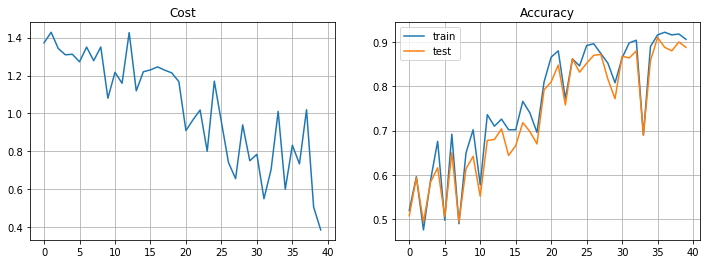

------------------------------------------------------------
ladybug: 0.9051383399209486 (229 / 253)
spider: 0.8704453441295547 (215 / 247)
------------------------------------------------------------
epoch 41 --- 2020/06/24 22:43:40
epoch 42 --- 2020/06/24 22:47:59
epoch 43 --- 2020/06/24 22:52:12
epoch 44 --- 2020/06/24 22:56:27
epoch 45 --- 2020/06/24 23:00:44
epoch 46 --- 2020/06/24 23:05:01
epoch 47 --- 2020/06/24 23:09:17
epoch 48 --- 2020/06/24 23:13:36
epoch 49 --- 2020/06/24 23:17:53
epoch 50 --- 2020/06/24 23:22:10


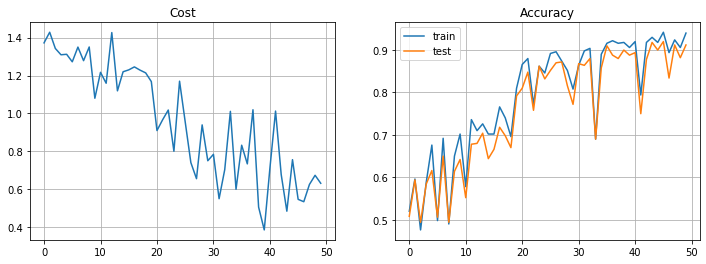

------------------------------------------------------------
ladybug: 0.8735177865612648 (221 / 253)
spider: 0.951417004048583 (235 / 247)
------------------------------------------------------------
epoch 51 --- 2020/06/24 23:26:58
epoch 52 --- 2020/06/24 23:31:13
epoch 53 --- 2020/06/24 23:35:28
epoch 54 --- 2020/06/24 23:39:42
epoch 55 --- 2020/06/24 23:44:02
epoch 56 --- 2020/06/24 23:48:19
epoch 57 --- 2020/06/24 23:52:34
epoch 58 --- 2020/06/24 23:56:50
epoch 59 --- 2020/06/25 00:01:06
epoch 60 --- 2020/06/25 00:05:25


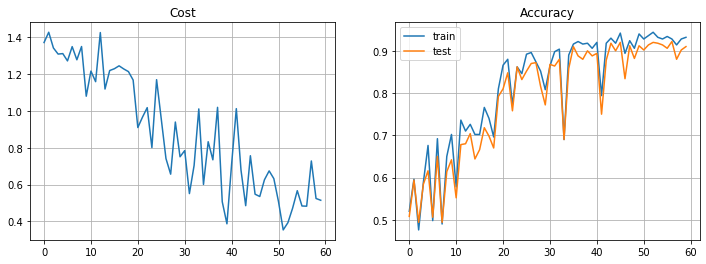

------------------------------------------------------------
ladybug: 0.9288537549407114 (235 / 253)
spider: 0.8906882591093117 (220 / 247)
------------------------------------------------------------
epoch 61 --- 2020/06/25 00:10:14
epoch 62 --- 2020/06/25 00:14:33
epoch 63 --- 2020/06/25 00:18:48
epoch 64 --- 2020/06/25 00:23:05
epoch 65 --- 2020/06/25 00:27:23
epoch 66 --- 2020/06/25 00:31:41
epoch 67 --- 2020/06/25 00:35:58
epoch 68 --- 2020/06/25 00:40:12
epoch 69 --- 2020/06/25 00:44:25
epoch 70 --- 2020/06/25 00:48:39


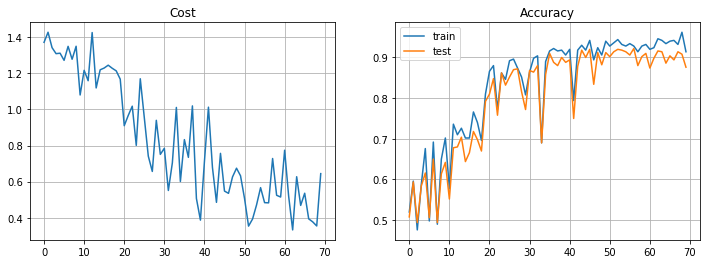

------------------------------------------------------------
ladybug: 0.7905138339920948 (200 / 253)
spider: 0.9635627530364372 (238 / 247)
------------------------------------------------------------
epoch 71 --- 2020/06/25 00:53:27
epoch 72 --- 2020/06/25 00:57:43
epoch 73 --- 2020/06/25 01:01:59
epoch 74 --- 2020/06/25 01:06:16
epoch 75 --- 2020/06/25 01:10:34
epoch 76 --- 2020/06/25 01:14:53
epoch 77 --- 2020/06/25 01:19:09
epoch 78 --- 2020/06/25 01:23:24
epoch 79 --- 2020/06/25 01:27:41
epoch 80 --- 2020/06/25 01:31:59


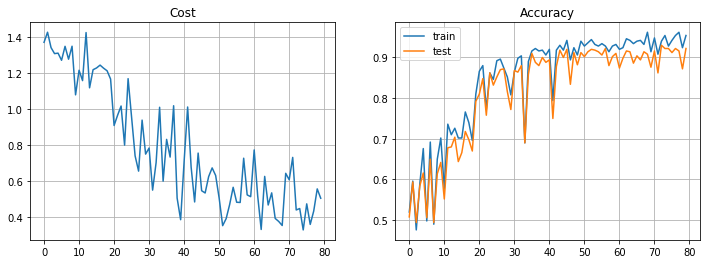

------------------------------------------------------------
ladybug: 0.9209486166007905 (233 / 253)
spider: 0.9230769230769231 (228 / 247)
------------------------------------------------------------
epoch 81 --- 2020/06/25 01:36:47
epoch 82 --- 2020/06/25 01:41:04
epoch 83 --- 2020/06/25 01:45:20
epoch 84 --- 2020/06/25 01:49:36
epoch 85 --- 2020/06/25 01:53:52
epoch 86 --- 2020/06/25 01:58:08
epoch 87 --- 2020/06/25 02:02:23
epoch 88 --- 2020/06/25 02:06:40
epoch 89 --- 2020/06/25 02:10:58
epoch 90 --- 2020/06/25 02:15:15


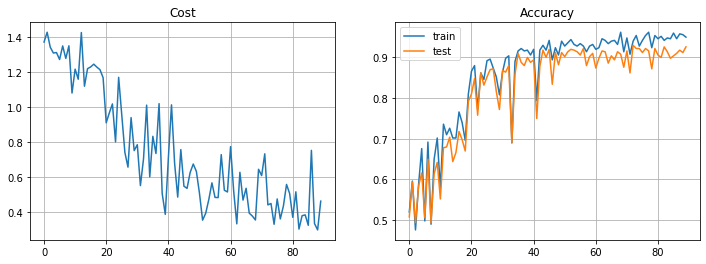

------------------------------------------------------------
ladybug: 0.9288537549407114 (235 / 253)
spider: 0.9230769230769231 (228 / 247)
------------------------------------------------------------
epoch 91 --- 2020/06/25 02:20:01
epoch 92 --- 2020/06/25 02:24:18
epoch 93 --- 2020/06/25 02:28:34
epoch 94 --- 2020/06/25 02:32:50
epoch 95 --- 2020/06/25 02:37:08
epoch 96 --- 2020/06/25 02:41:26
epoch 97 --- 2020/06/25 02:45:44
epoch 98 --- 2020/06/25 02:50:01
epoch 99 --- 2020/06/25 02:54:14
epoch 100 --- 2020/06/25 02:58:31


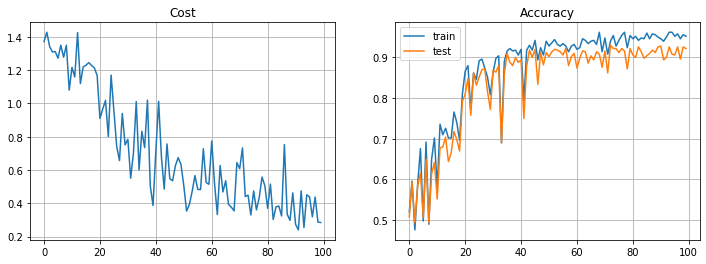

------------------------------------------------------------
ladybug: 0.9169960474308301 (232 / 253)
spider: 0.9271255060728745 (229 / 247)
------------------------------------------------------------


In [151]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pickle

#途中から再開する時
#with open('../data/tmp/vgg040.pkl', 'rb') as f:
#    vgg = pickle.load(f)

for i in range(10):
    vgg.fit(data_train, labels_train, data_test, labels_test)
    
    try:
        with open('../data/tmp/vgg.pkl'.format(len(vgg.cost)), 'wb') as f:
            pickle.dump(vgg, f)
    except OverflowError as err:
        print(err)
        
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title('Cost')
    plt.plot(range(len(vgg.cost)), vgg.cost)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(range(len(vgg.mse_train)), vgg.mse_train, label='train')
    plt.plot(range(len(vgg.mse_test)), vgg.mse_test, label='test')
    plt.grid()
    plt.legend()
    plt.show()

    """
    plt.figure(figsize=(6, 6))
    for i in range(cnn.FN):
        plt.subplot(cnn.FN//6, 6, i+1)
        plt.title(i)
        plt.xticks(color="None")
        plt.yticks(color="None")
        plt.tick_params(length=0)
        plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
    plt.show()
    """

    print('------------------------------------------------------------')
    for l in np.unique(labels_test):
        ids = labels_test == l
        imgs = data_test[ids]
        l_pred = vgg.predict(imgs)
        n_total = np.count_nonzero(ids)
        n_ok = np.count_nonzero(l_pred == l)
        print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))
    print('------------------------------------------------------------')

In [93]:
print(vgg.layers[0].filters.dtype)

float32


In [ ]:
if True:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title('Cost')
    plt.plot(range(len(vgg.cost)), vgg.cost)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(range(len(vgg.mse_train)), vgg.mse_train, label='train')
    plt.plot(range(len(vgg.mse_test)), vgg.mse_test, label='test')
    plt.grid()
    plt.legend()
    plt.show()

for l in np.unique(labels):
    ids = labels_test == l
    imgs = data_test[ids]
    l_pred = vgg.predict(imgs)
    n_total = np.count_nonzero(ids)
    n_ok = np.count_nonzero(l_pred == l)
    print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))

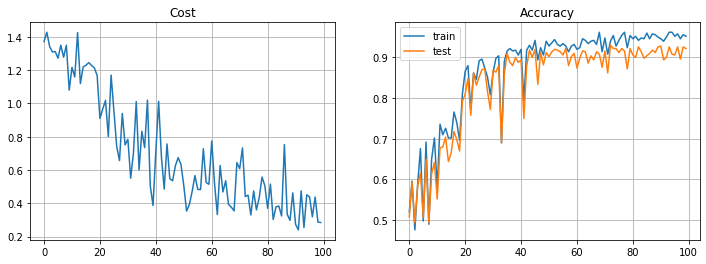

ladybug: 0.9169960474308301 (232 / 253)
spider: 0.9271255060728745 (229 / 247)


In [152]:
"""
ladybug: 0.9169960474308301 (232 / 253)
spider: 0.9271255060728745 (229 / 247)
"""
# モデルのパラメータはそのままで spider vs ladybug にしてみる（ladybug が判別しやすいだけ？）：精度9割超えた。
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=1024, h_layers=1, c_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)

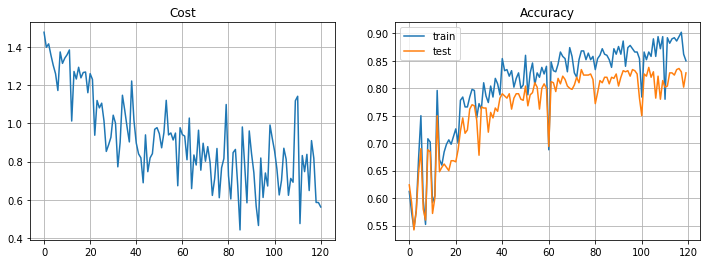

cockroach: 0.9087301587301587 (229 / 252)
ladybug: 0.7701612903225806 (191 / 248)


In [145]:
"""
cockroach: 0.9087301587301587 (229 / 252)
ladybug: 0.7701612903225806 (191 / 248)
"""
# モデルのパラメータはそのままで cockroach vs ladybug に戻してみる：やはり比較的高い精度
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=1024, h_layers=1, c_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)
if True:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title('Cost')
    plt.plot(range(len(vgg.cost)), vgg.cost)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(range(len(vgg.mse_train)), vgg.mse_train, label='train')
    plt.plot(range(len(vgg.mse_test)), vgg.mse_test, label='test')
    plt.grid()
    plt.legend()
    plt.show()

for l in np.unique(labels):
    ids = labels_test == l
    imgs = data_test[ids]
    l_pred = vgg.predict(imgs)
    n_total = np.count_nonzero(ids)
    n_ok = np.count_nonzero(l_pred == l)
    print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))

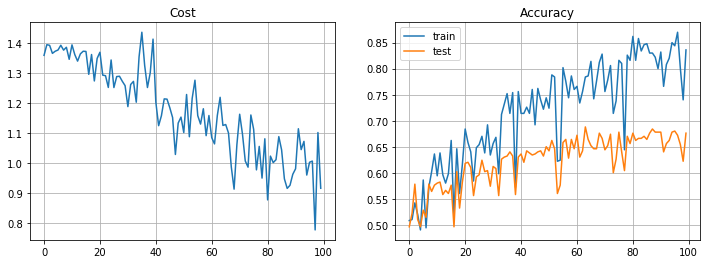

cockroach: 0.7410358565737052 (186 / 251)
spider: 0.6104417670682731 (152 / 249)


In [138]:
"""
cockroach: 0.7410358565737052 (186 / 251)
spider: 0.6104417670682731 (152 / 249)
"""
# 2値分類に戻す。これまでと異なり cockroach vs spider で分類。テストデータを100件増やす：あまり精度が出ない
# VGGLike, BNあり, Dropoutあり, 1000, 500
# 128x128 image
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=1024, h_layers=1, c_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)
if True:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title('Cost')
    plt.plot(range(len(vgg.cost)), vgg.cost)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(range(len(vgg.mse_train)), vgg.mse_train, label='train')
    plt.plot(range(len(vgg.mse_test)), vgg.mse_test, label='test')
    plt.grid()
    plt.legend()
    plt.show()

for l in np.unique(labels):
    ids = labels_test == l
    imgs = data_test[ids]
    l_pred = vgg.predict(imgs)
    n_total = np.count_nonzero(ids)
    n_ok = np.count_nonzero(l_pred == l)
    print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))

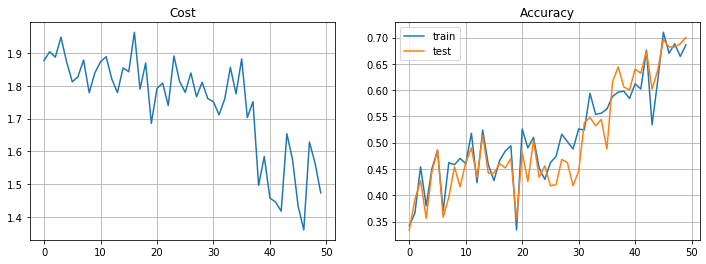

cockroach: 0.4266666666666667 (64 / 150)
ladybug: 0.8066298342541437 (146 / 181)
spider: 0.8284023668639053 (140 / 169)


In [108]:
"""
cockroach: 0.4266666666666667 (64 / 150)
ladybug: 0.8066298342541437 (146 / 181)
spider: 0.8284023668639053 (140 / 169)
"""
# 学習率は元に戻し（1e-3）、3値分類してみる。データも増やす。：結果は微妙。偏りが。
# VGGLike, BNあり, Dropoutあり, 1500, 500
# 128x128 image
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=1024, h_layers=1, c_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)

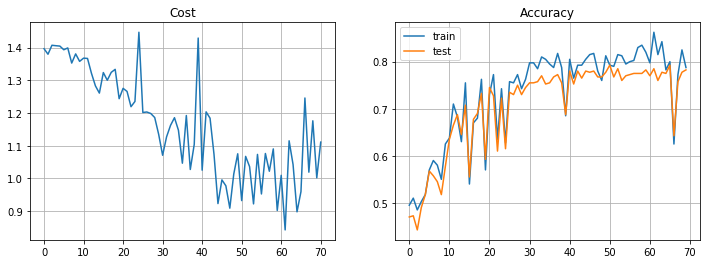

cockroach: 0.8677248677248677 (164 / 189)
ladybug: 0.7156398104265402 (151 / 211)


In [99]:
# 学習率を更に小さくしてみる（eta = 1e-3 -> 1e-4）：
# VGGLike, BNあり, Dropoutあり, 1000, 400
# 128x128 image
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=1024, h_layers=1, c_layers=3, epochs=10, eta=1e-4, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)

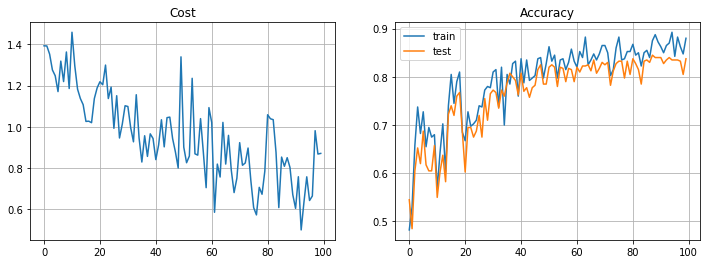

cockroach: 0.91005291005291 (172 / 189)
ladybug: 0.7725118483412322 (163 / 211)


In [96]:
"""
cockroach: 0.91005291005291 (172 / 189)
ladybug: 0.7725118483412322 (163 / 211)
"""
# 隠れ層を復活、学習率を小さく（eta = 1e-2 -> 1e-3）：精度向上。
# VGGLike, BNあり, Dropoutあり, 1000, 400
# 128x128 image
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=1024, h_layers=1, c_layers=3, epochs=10, eta=1e-3, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)

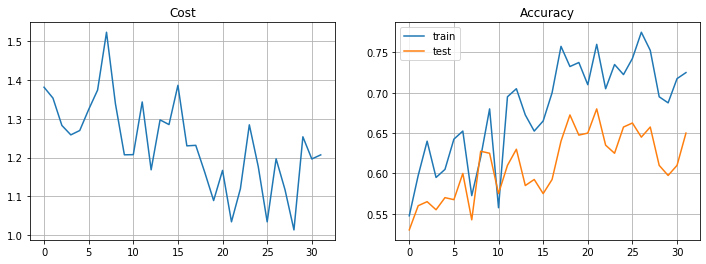

cockroach: 0.783068783068783 (148 / 189)
ladybug: 0.44549763033175355 (94 / 211)


In [91]:
# 隠れ層なくしてみた：精度が低下。隠れ層は必要っぽい
# VGGLike, BNあり, Dropoutあり, 1000, 400
# 128x128 image

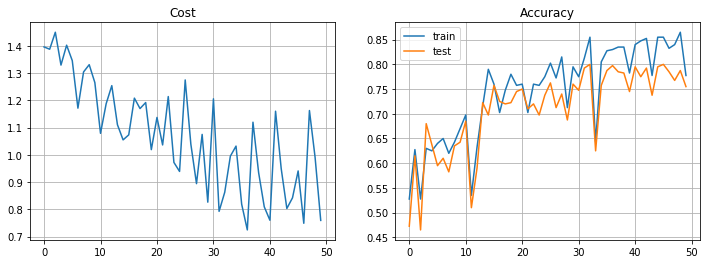

cockroach: 0.9629629629629629 (182 / 189)
ladybug: 0.5687203791469194 (120 / 211)


In [87]:
# 隠れ層のユニット増やしてみた（128 -> 1024）
# VGGLike, BNあり, Dropoutあり, 1000, 400
# 128x128 image
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=1024, h_layers=1, c_layers=3, epochs=10, eta=1e-2, n_batch=64, l2=0,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)
if True:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title('Cost')
    plt.plot(range(len(vgg.cost)), vgg.cost)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(range(len(vgg.mse_train)), vgg.mse_train, label='train')
    plt.plot(range(len(vgg.mse_test)), vgg.mse_test, label='test')
    plt.grid()
    plt.legend()
    plt.show()


for l in np.unique(labels):
    ids = labels_test == l
    imgs = data_test[ids]
    l_pred = vgg.predict(imgs)
    n_total = np.count_nonzero(ids)
    n_ok = np.count_nonzero(l_pred == l)
    print('{}: {} ({} / {})'.format(l, n_ok/n_total, n_ok, n_total))

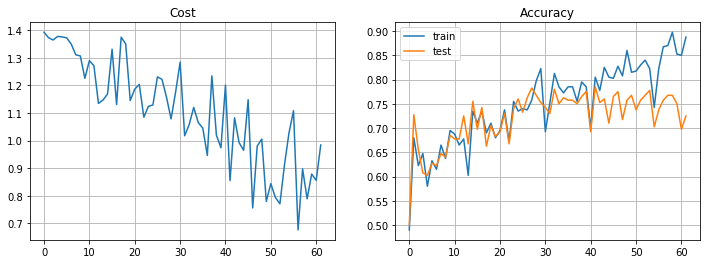

cockroach: 0.765 (153 / 200)
ladybug: 0.785 (157 / 200)


In [76]:
# 隠れ層のユニット増やしてみた（32 -> 128）
# VGGLike, BNあり, Dropoutあり, 1000, 400
# 128x128 image
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=128, h_layers=1, c_layers=3, epochs=10, eta=1e-2, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)

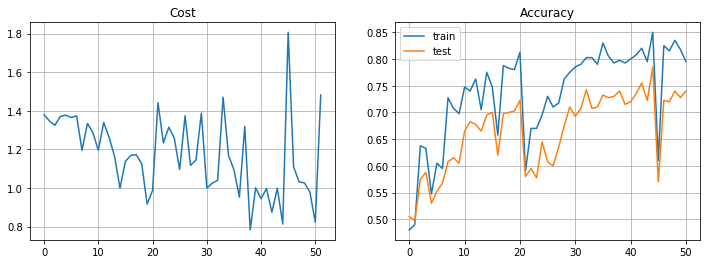

cockroach: 0.943078913324709 (729 / 773)
ladybug: 0.574385510996119 (444 / 773)


In [65]:
# MaxPooling 2層 -> 3層
# VGGLike, BNあり, Dropoutあり, 1000, 400
# 128x128 image
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=32, h_layers=1, c_layers=3, epochs=10, eta=1e-2, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)

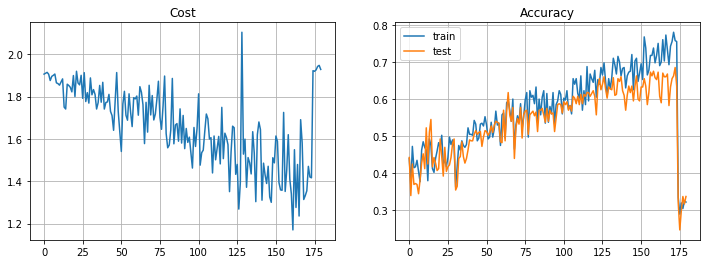

cockroach: 0.0 (0 / 773)
ladybug: 1.0 (773 / 773)
spider: 0.0 (0 / 773)


In [435]:
"""
170
------------------------------------------------------------
cockroach: 0.46153846153846156 (66 / 143)
ladybug: 0.7481481481481481 (101 / 135)
spider: 0.7049180327868853 (86 / 122)
------------------------------------------------------------
"""
# VGGLike, BNあり, Dropoutあり, 1000, 400
# 64x64 image
# vgg = VGGLikeCNN(FN=16, FH=3, FW=3, PH=2, PW=2, h_units=32, h_layers=1, c_layers=2, epochs=10, eta=1e-2, n_batch=64, l2=2e-3,
#                  dropout_ratio=0.3, stride_filter=1, pad_filter=1, stride_pool=2, pad_pool=0)

In [8]:
for layer in vgg.layers:
    if isinstance(layer, Convolution):
        print(layer.filters.shape)
        

(16, 3, 3, 3)
(16, 16, 3, 3)
(32, 16, 3, 3)
(32, 32, 3, 3)
(64, 32, 3, 3)
(64, 64, 3, 3)
